In [2]:
!pip install agentpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 715.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.7/778.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00


In [3]:
import agentpy as ap
import numpy as np
import seaborn as sns
import random

In [4]:
# Creamos el agente
class VacuumAgent(ap.Agent):

    # Función de percepción
    def see(self, e):
        self.per = 'dirty' if e[self.position] == 1 else 'clean'

    # Función next (actualizamos estados internos)
    def next(self, i, per):
        if per == "dirty":
            self.internal_states['is_dirty'] = True
        else:
            self.internal_states['is_dirty'] = False

    # Función acción
    def action(self, i):
        if i["is_dirty"]: # Si está sucio, limpiamos
            self.model.grid_labels[self.position] = 0  # Limpia la celda
            self.model.cleaned_cells += 1 # Aumentamos el numero de celdas que han sido limpiadas

        else: # Si no está sucio, movemos
            direction = random.choice(self.directions)
            new_x = self.position[0] + direction[0]
            new_y = self.position[1] + direction[1]
            new_pos = (new_x, new_y)
            if 0 <= new_x < self.model.width and 0 <= new_y < self.model.height:
                self.position = new_pos  # Actualiza la posición del agente


            self.model.total_movements += 1 # Aumentamos el numero de movimientos totales

    #-------------------------------------------#

    # Inicializamos atributos
    def setup(self):
        self.position = (1, 1) # Todos los agentes empiezan en el (1, 1)
        self.directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, -1), (-1, 1)] # Definimos todas las posibles direcciones en las que se puede mover el agente

        self.internal_states = {
            "is_dirty": False # Definimos un estado interno que nos diga si la celda actual esta sucia o no
        }

    # Se ejecuta en cada iteración
    def step(self):
        self.see(self.model.grid_labels)
        self.next(self.internal_states, self.per)
        self.action(self.internal_states)

    # Se ejecuta después del step
    def update(self):
        pass

    # Se ejecuta al final
    def end(self):
        pass

In [5]:
class VacuumModel(ap.Model):
    """
    Modelo de simulación para limpieza de una habitación con agentes aspiradora.
    """

    def setup(self):
        # Dimensiones de la habitación (MxN)
        self.grid_size = self.p['grid_size']
        M, N = self.grid_size, self.grid_size

        self.width = M
        self.height = N

        # Crear la cuadrícula
        self.grid = ap.Grid(self, (M, N))
        self.grid_labels = np.full((M, N), 0)

        # Número total de celdas
        total_cells = M * N

        # Porcentaje de celdas inicialmente sucias
        dirty_ratio = self.p['dirty_ratio']

        # Calcular el número de celdas sucias de forma segura
        num_dirty = int(total_cells * dirty_ratio)
        self.num_dirty = num_dirty

        # Crear agentes
        self.agents = ap.AgentList(self, self.p['num_agents'], VacuumAgent)
        self.grid.add_agents(self.agents, positions=[(1, 1)] * self.p['num_agents'])

        if num_dirty > total_cells:
            raise ValueError(f"Number of dirty cells ({num_dirty}) cannot exceed total number of cells ({total_cells}).")
        else:
            # Seleccionar posiciones aleatorias para las celdas sucias
            dirty_positions = self.random.sample(list(self.grid.all), num_dirty)
            for pos in dirty_positions:
                self.grid_labels[pos] = 1

        self.cleaned_cells = 0
        self.total_movements = 0

    def step(self):
        # Todos los agentes actúan
        self.agents.step()

        dirty_cells = self.grid_labels.sum()
        if dirty_cells == 0: # Si todas las celdas estan limpias, guardamos el numero de steps y paramos la simulación
            self.record('Steps necesarios', self.t)
            self.stop()


    def end(self):
        # Recolecta información al final de la simulación
        self.record('Porcentaje de celdas limpias', (self.cleaned_cells / (self.num_dirty)) * 100)
        self.record('Número de movimientos', self.total_movements)

parameters = {
    'grid_size': 10,  # MxN dimensiones de la habitación
    'num_agents': 9,  # Número de agentes
    'dirty_ratio': 0.3,  # Porcentaje de celdas inicialmente sucias
    'steps': 130,  # Tiempo máximo de ejecución
    'seed': 13,
}

model = VacuumModel(parameters)
results = model.run()

# Mostrar resultados
print(results.variables.VacuumModel)

Completed: 130 steps
Run time: 0:00:00.080807
Simulation finished
     Porcentaje de celdas limpias  Número de movimientos
t                                                       
130                     96.666667                   1141


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Definir distintos parámetros para el número de agentes
num_agents_list = [1, 2, 5, 7, 10, 12, 15, 20]

# Lista para guardar los resultados
results_list = []

for num_agents in num_agents_list:
    parameters = {
        'grid_size': 12,
        'num_agents': num_agents,
        'dirty_ratio': 0.4,
        'steps': 200,
    }
    model = VacuumModel(parameters)
    results = model.run()
    results_list.append({
        'num_agents': num_agents,
        'percentage_clean': results.variables.VacuumModel['Porcentaje de celdas limpias'],
        'total_movements': results.variables.VacuumModel['Número de movimientos'],
        'steps_needed': results.variables.VacuumModel.get('Steps necesarios', parameters['steps'])  # Usa el valor por defecto si no se detiene antes
    })

# Convertir los resultados a un DataFrame para facilitar la graficación
results_df = pd.DataFrame(results_list)


Completed: 200 steps
Run time: 0:00:00.029226
Simulation finished
Completed: 200 steps
Run time: 0:00:00.048473
Simulation finished
Completed: 200 steps
Run time: 0:00:00.058909
Simulation finished
Completed: 200 steps
Run time: 0:00:00.101133
Simulation finished
Completed: 200 steps
Run time: 0:00:00.066710
Simulation finished
Completed: 153 steps
Run time: 0:00:00.054298
Simulation finished
Completed: 151 steps
Run time: 0:00:00.083259
Simulation finished
Completed: 193 steps
Run time: 0:00:00.139627
Simulation finished


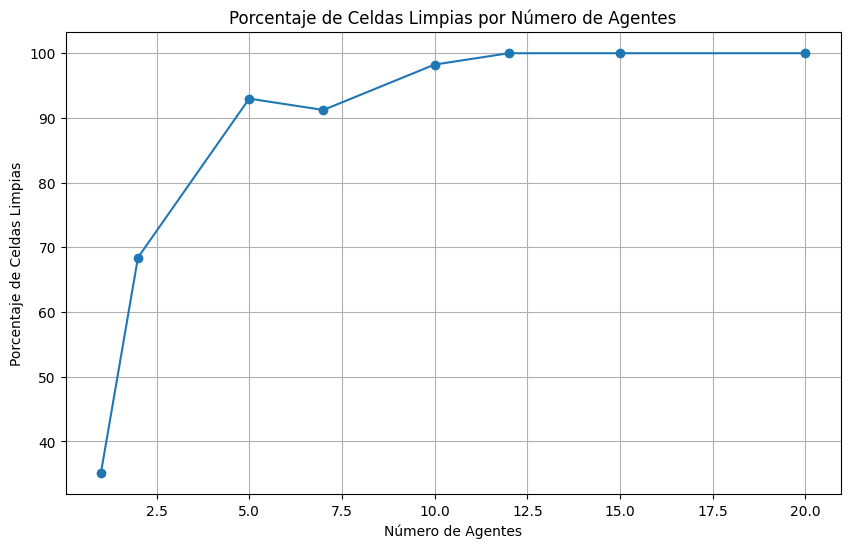

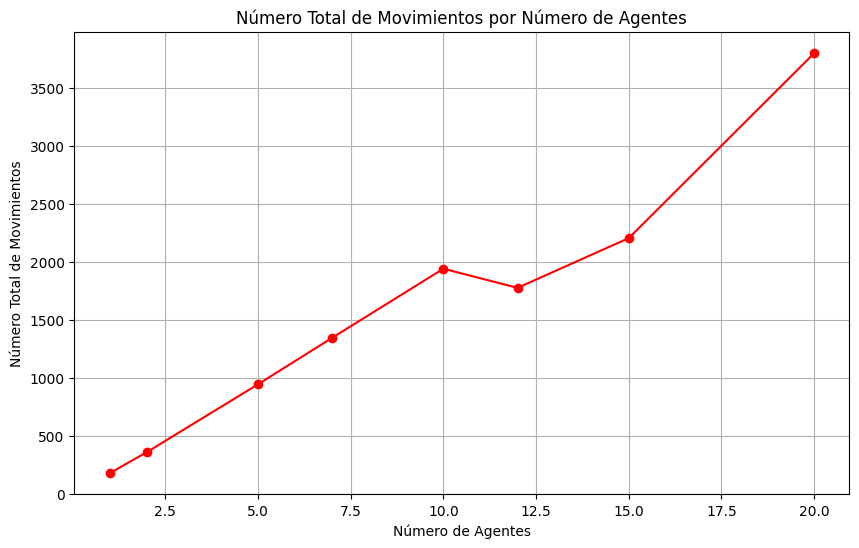

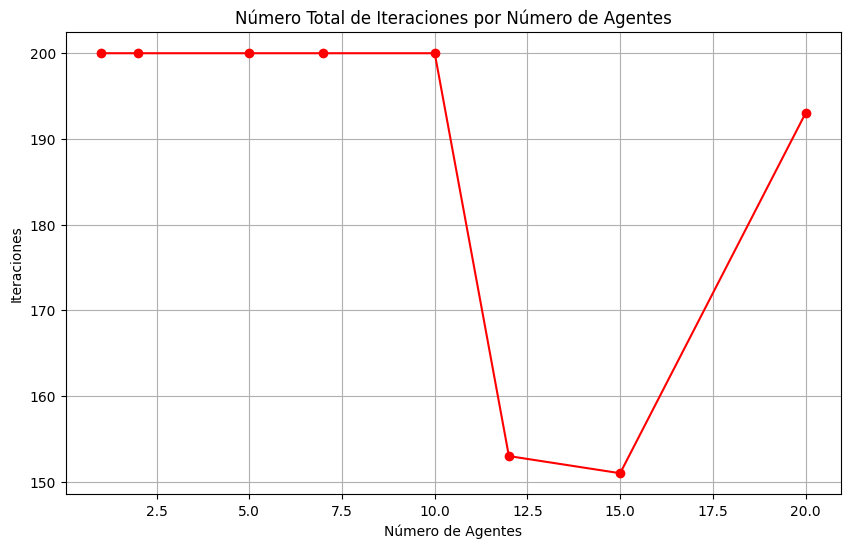

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['num_agents'], results_df['percentage_clean'], marker='o', linestyle='-')
plt.title('Porcentaje de Celdas Limpias por Número de Agentes')
plt.xlabel('Número de Agentes')
plt.ylabel('Porcentaje de Celdas Limpias')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_df['num_agents'], results_df['total_movements'], marker='o', linestyle='-', color='r')
plt.title('Número Total de Movimientos por Número de Agentes')
plt.xlabel('Número de Agentes')
plt.ylabel('Número Total de Movimientos')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_df['num_agents'], results_df['steps_needed'], marker='o', linestyle='-', color='r')
plt.title('Número Total de Iteraciones por Número de Agentes')
plt.xlabel('Número de Agentes')
plt.ylabel('Iteraciones')
plt.grid(True)
plt.show()
